<div class="alert alert-info">

Launch in Binder     [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?filepath=doc%2FNotebooks%2Fexamples%2FUK_Precipitation.ipynb)

<!-- Or launch an [Rstudio instance](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?urlpath=rstudio?filepath=doc%2FNotebooks%2FExamples.ipynb)
 -->
</div>

# UK Precipitation




## February 2020 case study
February 2020 was the wettest February on record in the UK (since 1862), [according to the Met Office](https://www.metoffice.gov.uk/about-us/press-office/news/weather-and-climate/2020/2020-winter-february-stats). The UK faced three official storms during February, and this exceptional phenomena attracted media attention, such as an article from the [BBC](https://www.bbc.com/news/science-environment-51713172) on increased climate concerns among the population. 

Here, we will test the applicability and potential of using SEAS5 for estimating the likelihood of the 2020 UK February precipitation event.


### Retrieve data

<div class="alert alert-info">

Note
    
In this notebook you cannot use the python functions under Retrieve and Preprocess (they are here only for documentation on the entire workflow, see [retrieve](../1.Download/1.Retrieve.ipynb) if you want to download your own dataset. The resulting preprocessed dataset is provided so you can perform statistical analysis on the dataset and rerun the evaluation and examples provided.
    
</div>

The main functions to retrieve all forecasts (SEAS5) is `retrieve_SEAS5`. We want to download February average precipitation over the UK. By default, the hindcast years of 1981-2016 are downloaded for SEAS5. The folder indicates where the files will be stored, in this case outside of the UNSEEN-open repository, in a 'UK_example' directory. For more explanation, see [retrieve](../1.Download/1.Retrieve.ipynb).

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
os.chdir(os.path.abspath('../../../'))

import src.cdsretrieve as retrieve
import src.preprocess as preprocess

In [29]:
import numpy as np
import xarray as xr

In [4]:
retrieve.retrieve_SEAS5(variables = 'total_precipitation', 
                        target_months = [2],
                        area = [60, -11, 50, 2],
                        years=np.arange(1981, 2021),
                        folder = '../UK_example/SEAS5/')

We use the EOBS observational dataset to evaluate the UNSEEN ensemble. I tried to download EOBS through the Copernicus Climate Data Store, but the Product is temporally disabled for maintenance purposes. As workaround I downloaded EOBS (from 1950 - 2019) and the most recent EOBS data (2020) [here](https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php). Note, you have to register as E-OBS user.

### Preprocess

In the preprocessing step, we first merge all downloaded files into one xarray dataset, see [preprocessing](https://unseen-open.readthedocs.io/en/latest/Notebooks/2.Preprocess/2.Preprocess.html#Merge). 

In [6]:
SEAS5_UK = preprocess.merge_SEAS5(folder = '../UK_example/SEAS5/', target_months = [2])

Lead time: 01
12
11
10
9


The SEAS5 total precipitation rate is in m/s. You can easily convert this and change the attributes.
Click on the show/hide attributes button to see the assigned attributes.

In [22]:
SEAS5_UK['tprate'] = SEAS5_UK['tprate'] * 1000 * 3600 * 24 ## From m/s to mm/d
SEAS5_UK['tprate'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}
SEAS5_UK

,Array,Chunk
Bytes,6.13 MB,31.42 kB
Shape,"(5, 39, 51, 11, 14)","(1, 1, 51, 11, 14)"
Count,2281 Tasks,195 Chunks
Type,float32,numpy.ndarray


Then I open the EOBS dataset and extract February monthly mean precipitation. I have taken the average mm/day over the month, which is more fair than the total monthly precipitation because of leap days. 

In [30]:
EOBS = xr.open_dataset('../UK_example/EOBS/rr_ens_mean_0.25deg_reg_v20.0e.nc') ## open the data
EOBS = EOBS.resample(time='1m').mean() ## Monthly averages
EOBS = EOBS.sel(time=EOBS['time.month'] == 2) ## Select only February
EOBS

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 70)
Coordinates:
  * time       (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2019-02-28
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
Data variables:
    rr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

Here I define the attributes, that xarray uses when plotting

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


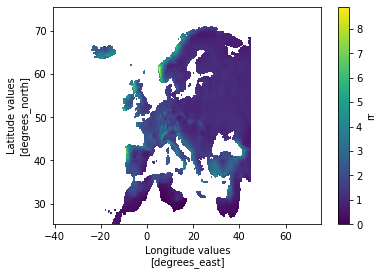

In [31]:
EOBS['rr'].attrs = {'long_name': 'rainfall',  ##Define the name
 'units': 'mm/day', ## unit
 'standard_name': 'thickness_of_rainfall_amount'} ## original name, not used
EOBS['rr'].mean('time').plot() ## and show the 1950-2019 average February precipitation 

The 2020 data file is separate and needs the same preprocessing:

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-31 2020-02-29 ... 2020-12-31
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
Data variables:
    rr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

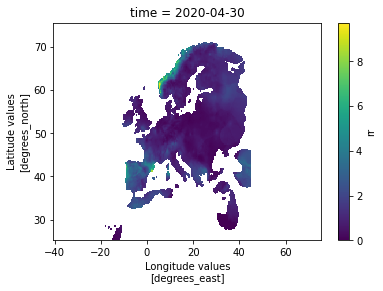

In [32]:
EOBS2020 = xr.open_dataset('../UK_example/EOBS/rr_0.25deg_day_2020_grid_ensmean.nc.1') #open
EOBS2020 = EOBS2020.resample(time='1m').mean() #Monthly mean
EOBS2020['rr'].sel(time='2020-04').plot() #show map
EOBS2020 ## display dataset

We then extract UK averaged precipitation for SEAS5 and EOBS. We upscale EOBS to the SEAS5 grid and apply the same UK mask to extract the UK average for both datasets. [Using EOBS + upscaling](../2.Preprocess/2.3Upscale.ipynb) shows how to regrid and extract the country average timeseries. 

Here, we export the SEAS5 and EOBS datasets as NetCDF files to be imported in the other notebook. 
Note that for EOBS we had to download two separate files, which we concatenate below before exporting as nc. 

In [33]:
SEAS5_UK.to_netcdf('../UK_example/SEAS5/SEAS5_UK.nc') ## Store SEAS5 as NetCDF for future import

EOBS_concat = xr.concat([EOBS,EOBS2020.sel(time='2020-02')],dim='time') ## Concatenate the 1950-2019 and 2020 datasets. 
EOBS_concat.to_netcdf('../UK_example/EOBS/EOBS_UK.nc') ## And store the 1950-2010 February precipitation into one nc for future import 

### Evaluate


<div class="alert alert-info">

Note

From here onward we use R and not python!
    
We switch to R since we believe R has a better functionality in extreme value statistics. 

</div>

In [1]:
setwd('../../..')
# getwd()
EOBS_UK_weighted_df <- read.csv("Data/EOBS_UK_weighted_upscaled.csv", stringsAsFactors=FALSE)
SEAS5_UK_weighted_df <- read.csv("Data/SEAS5_UK_weighted_masked.csv", stringsAsFactors=FALSE)

## Convert the time class to Date format
EOBS_UK_weighted_df$time <- lubridate::ymd(EOBS_UK_weighted_df$time)
str(EOBS_UK_weighted_df)

EOBS_UK_weighted_df_hindcast <- EOBS_UK_weighted_df[
    EOBS_UK_weighted_df$time > '1982-02-01' &
    EOBS_UK_weighted_df$time < '2017-02-01',
    ]


SEAS5_UK_weighted_df$time <- lubridate::ymd(SEAS5_UK_weighted_df$time)
str(SEAS5_UK_weighted_df)

'data.frame':	71 obs. of  2 variables:
 $ time: Date, format: "1950-02-28" "1951-02-28" ...
 $ rr  : num  4.13 3.25 1.07 1.59 2.59 ...
'data.frame':	9945 obs. of  4 variables:
 $ leadtime: int  2 2 2 2 2 2 2 2 2 2 ...
 $ number  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ time    : Date, format: "1982-02-01" "1983-02-01" ...
 $ tprate  : num  1.62 2.93 3.27 2 3.31 ...


*Is the UNSEEN ensemble realistic?* 

To answer this question, we perform three statistical tests: independence, model stability and model fidelity tests.  
These statistical tests are available through the [UNSEEN R package](https://github.com/timokelder/UNSEEN). 
See [evaluation](../3.Evaluate/3.Evaluate.ipynb) for more info.

In [2]:
require(UNSEEN)
require(ggplot2)
require(ggpubr)


Loading required package: UNSEEN

Loading required package: ggplot2

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
Loading required package: ggpubr



#### Timeseries
<a id='Timeseries'></a>

We plot the timeseries of SEAS5 (UNSEEN) and EOBS (OBS) for UK February precipitation. 

You can call the documentation of the function with `?unseen_timeseries`

Warning message:
“Removed 4654 rows containing non-finite values (stat_boxplot).”


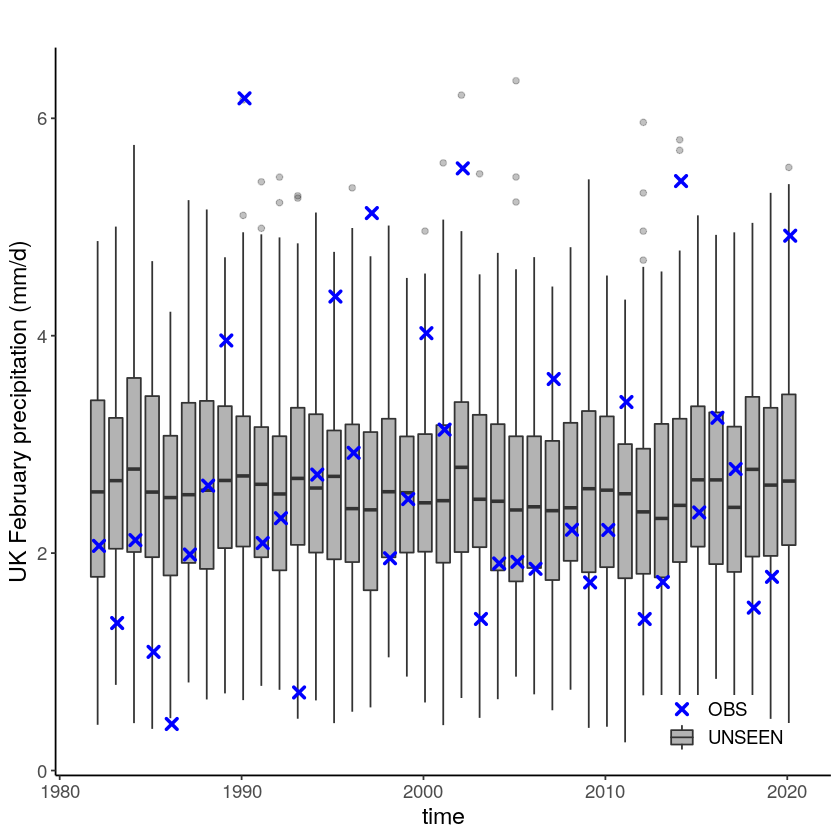

In [3]:
unseen_timeseries(ensemble = SEAS5_UK_weighted_df,
                               obs = EOBS_UK_weighted_df[EOBS_UK_weighted_df$time > '1982-02-01',],
                               ylab = 'UK February precipitation (mm/d)') + 
theme(text = element_text(size = 14)) #This is just to increase the figure font

We select the timeseries for the **hindcast years 1981-2016**. 

In [4]:
SEAS5_UK_hindcast <- SEAS5_UK_weighted_df[
    SEAS5_UK_weighted_df$time < '2017-02-01' &
    SEAS5_UK_weighted_df$number < 25,]

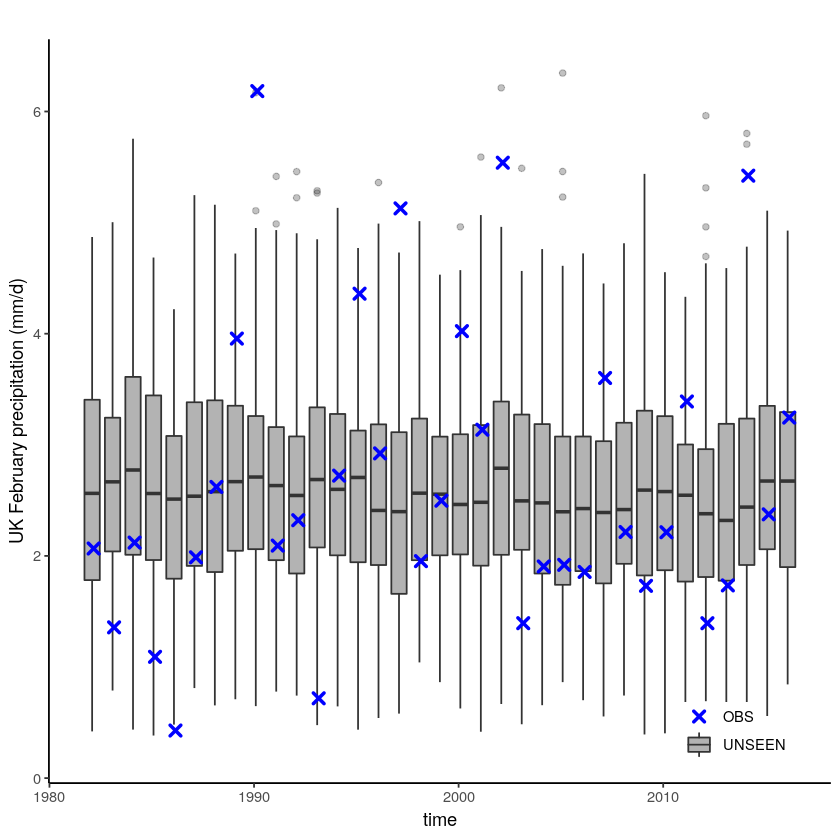

In [5]:
unseen_timeseries(ensemble = SEAS5_UK_hindcast,
                  obs = EOBS_UK_weighted_df_hindcast,
                  ylab = 'UK February precipitation (mm/d)')#  %>% 
# ggsave(height = 5, width = 6,   filename = "graphs/UK_timeseries.png")

#### Evaluation tests
With the hindcast dataset we evaluate the independence, stability and fidelity. 

First the *independence test*. This test checks if the forecasts are independent. If they are not, the event are not unique and care should be taken in the extreme value analysis. Because of the chaotic behaviour of the atmosphere, independence of precipitation events is expected beyond a lead time of two weeks. Here we use lead times 2-6 months and find that the boxplots are within the expected range (perhaps very small dependence in lead time 2). More info in our paper: https://doi.org/10.1038/s41612-020-00149-4.


Warning message:
“Removed 1625 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1625 rows containing non-finite values (stat_boxplot).”


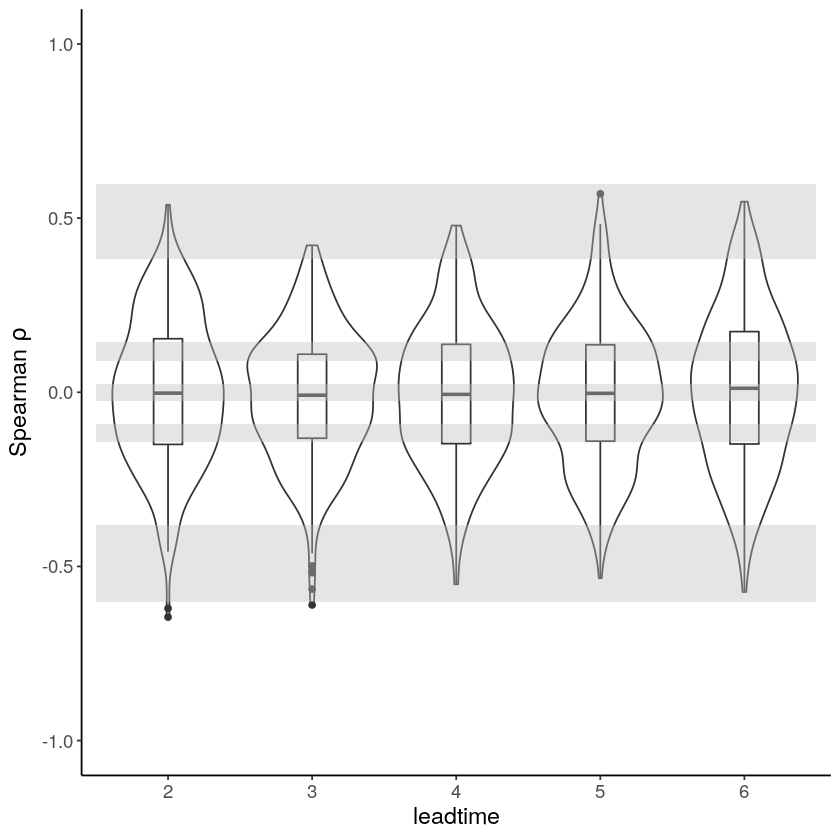

In [6]:
Independence_UK = independence_test(ensemble = SEAS5_UK_hindcast,
                                   detrend = TRUE) +
    theme(text = element_text(size = 14))

Independence_UK

The test for *model stability*: Is there a drift in the simulated precipitation over lead times?

We find that the model is stable for UK February precipitation.

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


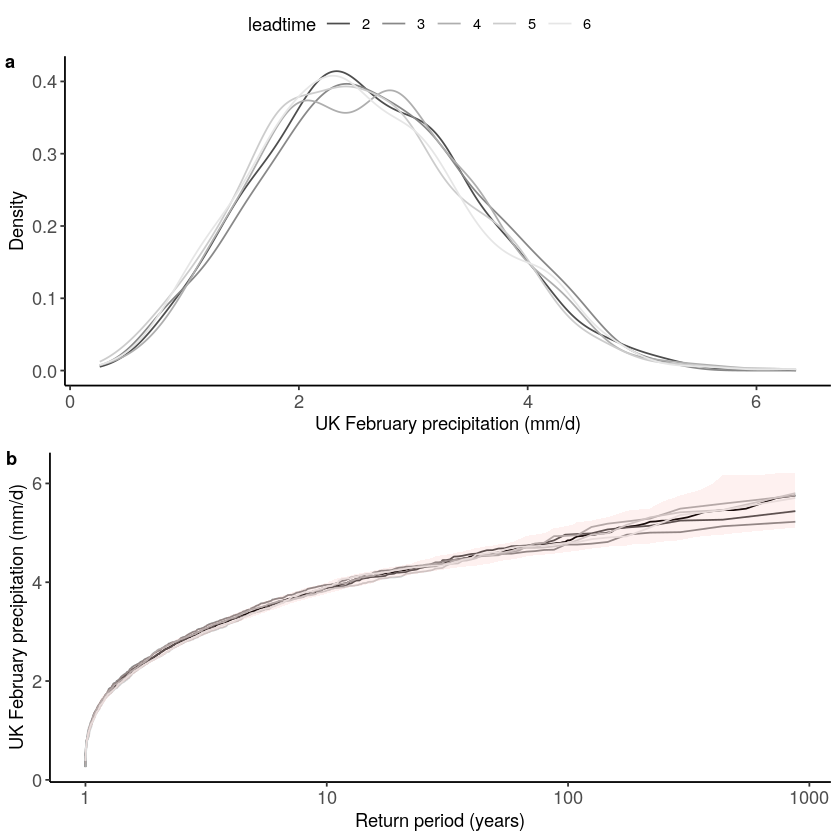

In [7]:
Stability_UK = stability_test(ensemble = SEAS5_UK_hindcast,
                              lab = 'UK February precipitation (mm/d)')

Stability_UK

The *fidelity test* shows us how consistent the model simulations of UNSEEN (SEAS5) are with the observed (EOBS). With this test we can asses systematic biases. The UNSEEN dataset is much larger than the observed -- hence they cannot simply be compared. For example, what if we had faced a few more or a few less precipitation extremes purely by chance? 

This would influence the observed mean, but not so much influence the UNSEEN ensemble because of the large data sample. Therefore we express the UNSEEN ensemble as a range of plausible means, for data samples of the same length as the observed. We do the same for higher order [statistical moments](https://en.wikipedia.org/wiki/Moment_(mathematics)). 

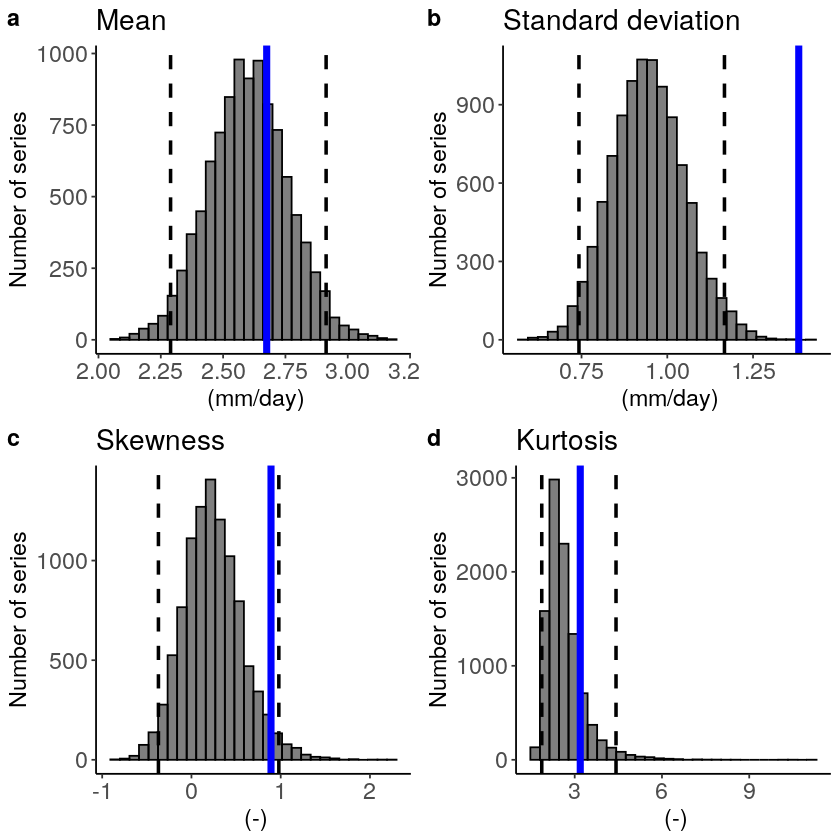

In [8]:
Fidelity_UK = fidelity_test(obs = EOBS_UK_weighted_df_hindcast$rr,
                            ensemble = SEAS5_UK_hindcast$tprate,
                            fontsize = 14
                            )
Fidelity_UK

We find that the standard deviation within the model (the grey histograms and lines) are too low compared to the observed. 

We can include a simple mean-bias correction (ratio) in this plot by setting `biascor = TRUE`. However, in this case it won't help:

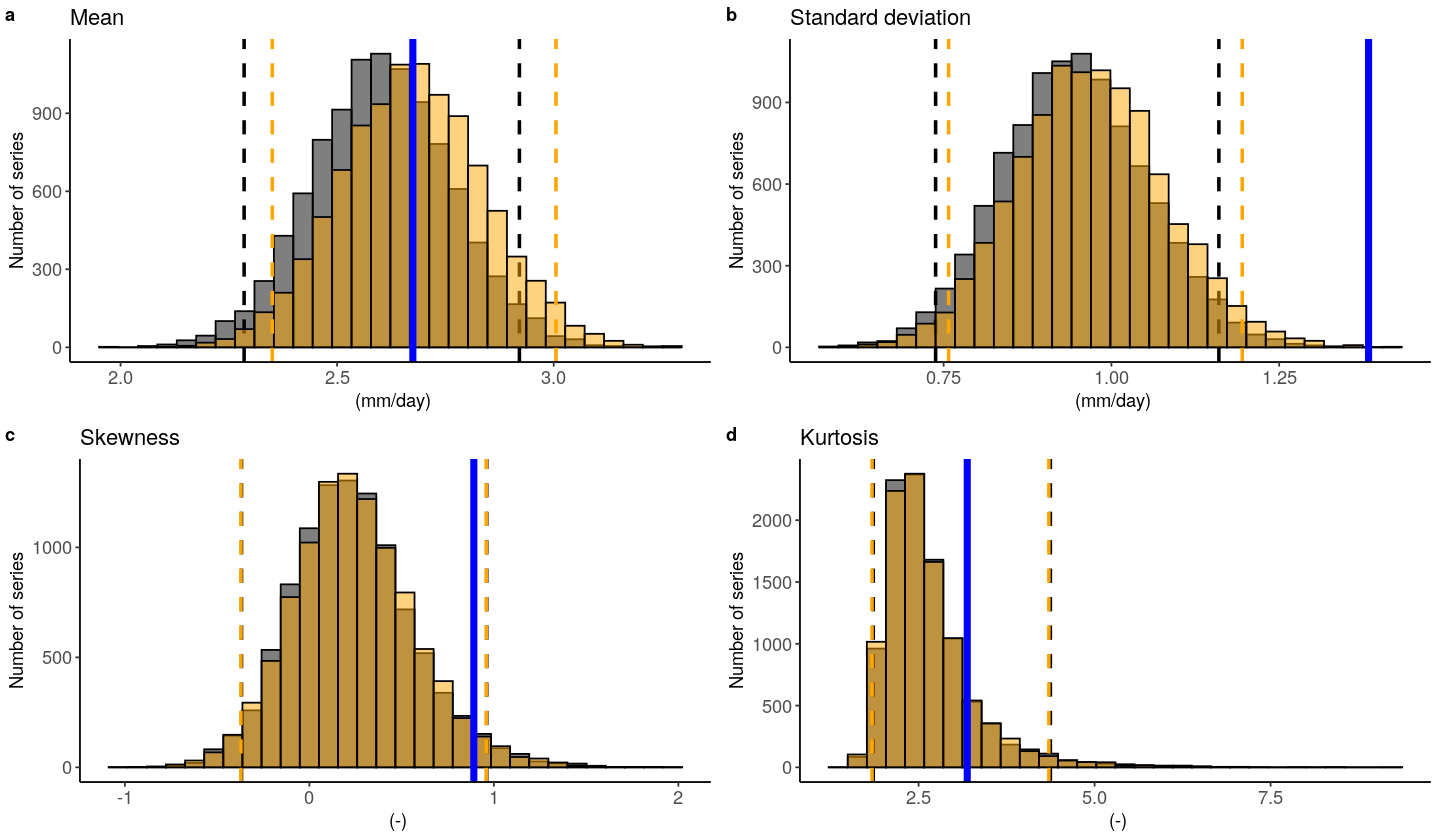

In [16]:
fidelity_test(obs = EOBS_UK_weighted_df_hindcast$rr, 
              ensemble = SEAS5_UK_hindcast$tprate, 
              biascor = TRUE
             )

Check the documentation of the test `?fidelity_test`

### Illustrate

First, we fit a Gumbel and a GEV distribution (including shape parameter) to the observed extremes. The Gumbel distribution best describes the data because the p-value of 0.9 is much above 0.05 (based on the likelihood ratio test). 

In [9]:
fit_obs_Gumbel <- fevd(x = EOBS_UK_weighted_df_hindcast$rr,
                    type = "Gumbel"
                   )
fit_obs_GEV <- fevd(x = EOBS_UK_weighted_df_hindcast$rr,
                    type = "GEV"
                   )
lr.test(fit_obs_Gumbel, fit_obs_GEV)


	Likelihood-ratio Test

data:  EOBS_UK_weighted_df_hindcast$rrEOBS_UK_weighted_df_hindcast$rr
Likelihood-ratio = 0.014629, chi-square critical value = 3.8415, alpha
= 0.0500, Degrees of Freedom = 1.0000, p-value = 0.9037
alternative hypothesis: greater


We show the gumbel plot for the observed (EOBS) and UNSEEN (SEAS5 hindcast data). This shows that the UNSEEN simulations are not within the uncertainty range of the observations. This has to do with the variability of the model that is too low, as indicated in the evaluation section. The `EVT_plot` function was written for this case study, but we cannot ensure robustness to other case studies.

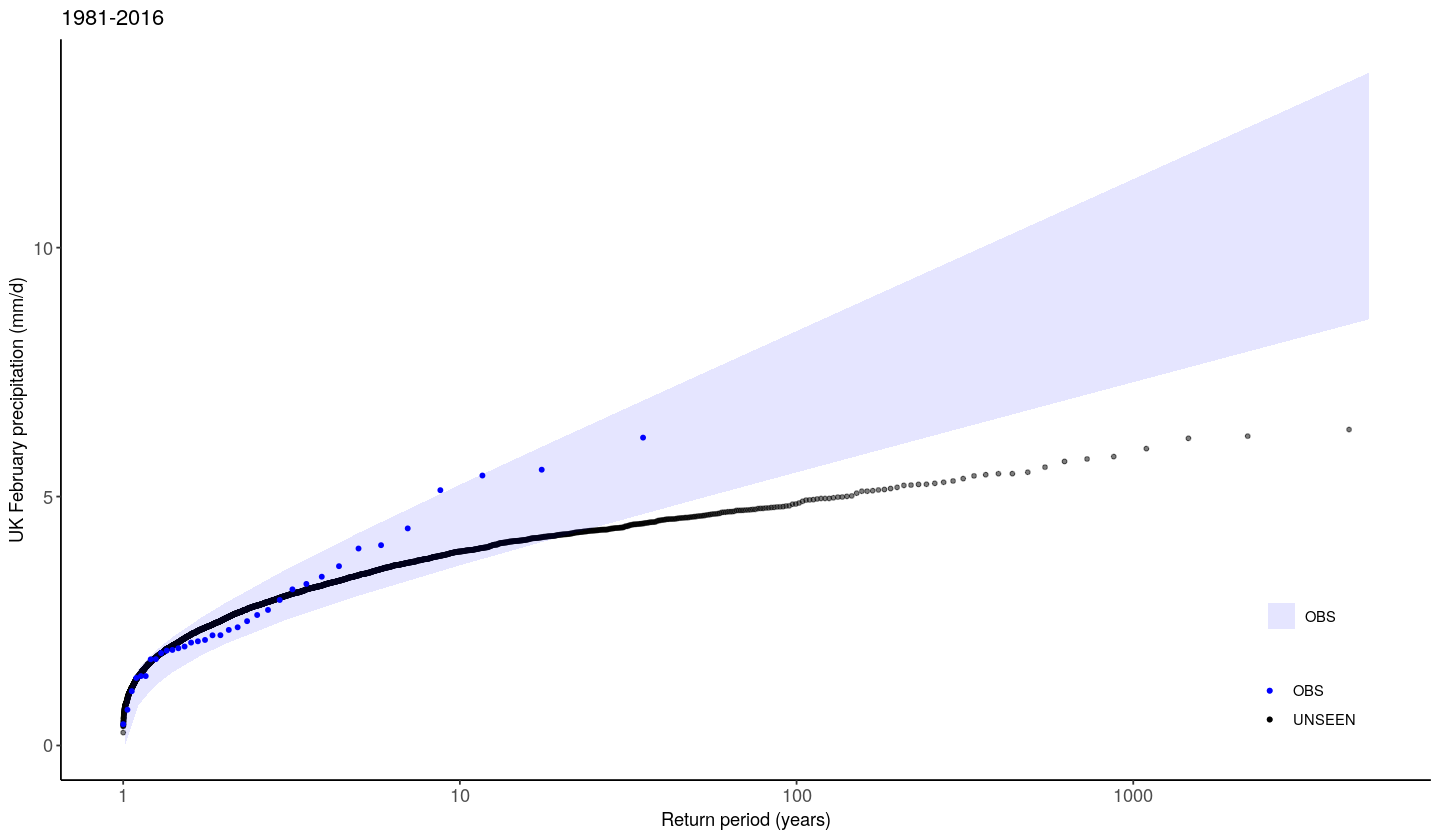

In [14]:
source('src/evt_plot.r')
options(repr.plot.width = 12)
EVT_plot(ensemble = SEAS5_UK_hindcast$tprate,
                     obs = EOBS_UK_weighted_df_hindcast$rr,
                     main = "1981-2016",
                     GEV_type = "Gumbel",
#                          ylim = 3,
                     y_lab = 'UK February precipitation (mm/d)'
         )

### Potential

We find that there is there too little variability within SEAS5 hindcasts of UK february precipitation.
It might be resolution dependent or related to the signal-to-noise that is a problem over this region. The results can be fed back to model developers to help improve the models. 

The use of other observational datasets and other model simulations can be further explored. 
For example, the UK Met Office studied UK monthly precipitation extremes using the UNSEEN method ([Thompson et al., 2017](https://www.nature.com/articles/s41467-017-00275-3)). They showed that monthly precipitation records for south east England have a 7% chance of being exceeded in at least one month in any given winter. Their work was taken up in the [UK National Flood Resilience Review (2016)](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/551137/national-flood-resilience-review.pdf), showing the high relevance of the method. 